### Description of Data

Our goal is to construct a low-rank approximation of a data matrix $A$ of DNA methylation patterns (with many missing data points). Each row of $A$ contains a binary sequence of methylation, $A_{ij} = 1$ for methylated sites, $A_{ij} = 0$ for unmethylated sites, and $A_{ij} = \text{NA}$ when site $j$ is unobserved in read $i$.

We suspect that $A$ is low-rank, since similar methylation patterns should be observed across reads originating from the same cell type. The code below plots some synthetic data with 2 underlying cell types (red and blue).

INFO: Loading help data...


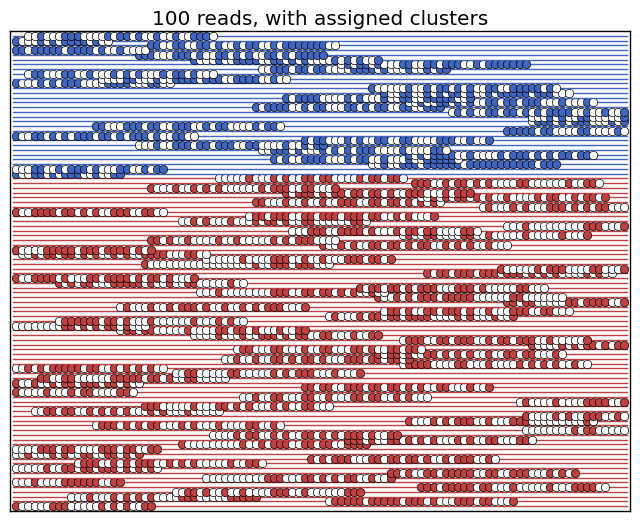

In [1]:
using LowRankModels
using Distributions
include("methylation_functions.jl"); 

## Plot an example data matrix "A" with 100 reads, each with length 20
A,P,c = generate_reads(N=100,W=30)
plot_meth(A,c)
title("100 reads, with assigned clusters")

# Get matrix dimensions and indices of observed datapoints A_ij
m,n = size(A)
k = 2 # Assume we know there are two cell types

function find_observations(A)
    m,n = size(A)
    obs = (Int64,Int64)[]
    for i = 1:m
        for j = 1:n
            if ~isnan(A[i,j])
                push!(obs,(i,j))
            end
        end
    end
    return obs
end

obs = find_observations(A);

### Matrix Factorization/Completion Approach

To obtain a low-rank approximation, we factor $A$ as a product of two matrices $X$ and $Y$:

$$
A = XY \\ A \in \mathbf{R}^{m \times n},~~ X \in \mathbf{R}^{m \times k},~~ Y \in \mathbf{R}^{k \times n}
$$

That is, we have a dataset $m$ reads that provide partial information over $n$ methylation-eligible sites of interest (e.g. over a selected number of genes, or, more ambitiously, over the entire genome). We suppose that there are no more than $k$ types of cells with distinct methylation patterns.

We restrict the rows of $X$ to be nonnegative, so that each row of $A$ is approximated as a weighted sum of the $k$ different methylation patterns shown in the rows of $Y$. An interesting question is whether we believe the rows of $X$ to be sparse. An $X$ with sparse rows would correspond to there being distinct methylation patterns across cell types, with little to no mixed patterns. An $X$ with non-sparse rows would allow for a spectrum of different DNA methylation profiles.

For the purposes of this preliminary analysis, we focus on the case where the rows of $X$ are sparse. This matches the synthetic data plotted above.

### Optimization Framework

We use $x_i$ to denote row $i$ of $X$, and $y_j$ to denote column $j$ of $Y$, so that $x_i y_j$ is a vector dot product. Let $(i,j) \in \Omega$ denote the indices of observed entries in $A$. Then a low-rank approximation can be achieved by solving the unconstrained optimization problem (see [Udell et al., 2014](http://web.stanford.edu/~udell/doc/glrm.pdf)):

$$
\begin{aligned}
& \underset{X,Y}{\text{minimize}}
& & \sum_{(i,j) \in \Omega} L(A_{ij},x_i y_j) - \gamma_x \sum_i r_x(x_i) - \gamma_x \sum_j r_y(y_j) 
\end{aligned}
$$

Here $L(\cdot)$ is the loss function of choice; $r_x(\cdot)$ and $r_y(\cdot)$ regularize the rows and columns of $X$ and $Y$ respectively; the set $\Omega$ holds the observed entries of $A$ (i.e. we ignore all $A_{ij} = \text{NA}$). We will use the [LowRankModels package](https://github.com/madeleineudell/LowRankModels.jl) in Julia to solve problems in this format. The functions below will help us fit these models:

In [2]:
function run_fit(loss,rx,ry,initX,initY)
    ## Fits a low-rank model given:
    ##   loss()      -- the loss function
    ##   rx(),ry()   -- regularization functions
    ##   initX,initY -- initial guesses for X,Y
    losses = fill(loss,n)
    glrm = GLRM(A,obs,losses,rx,ry,k)
    
    if initX != nothing
        glrm.X = initX
    end
    if initY != nothing
        glrm.Y = initY
    end
    X,Y,ch = fit!(glrm,verbose=false)
    return X,Y,ch
end

function run_batch(loss_function,rx,ry,initX,initY,N)
    ## Fits a specified low-rank model N times, returns best one
    best = Inf
    X,Y,ch = 0,0,0
    for i = 1:N
        Xest,Yest,ch_ = run_fit(loss_function,rx,ry,initX,initY)
        if ch_.objective[end] < best
            best = ch_.objective[end]
            X,Y,ch = Xest,Yest,ch_
        end
    end
    println("Best Objective: ",ch.objective[end])
    return X,Y,ch
end

function evaluate_loss(loss_function,rx,ry;N=20,initX=nothing,initY=nothing)
    ## Fits a low-rank model N times, and compares output to ground truth
    X,Y,ch = run_batch(loss_function,rx,ry,initX,initY,N);
    
    # reconstruct "true" x
    x_real = zeros(size(X))
    for i = 1:m
        x_real[i,c[i]] = 1
    end
    
    # re-sort the rows and columns of X so that the largest cluster is first
    c_order = sortperm(squeeze(sum(X,1),1),rev=true)
    X = X[:,c_order]
    Y = Y[c_order,:]
    
    # Compare true and inferred cluster assignments
    matshow(X',cmap=ColorMap("Greys"))
    xlabel("Inferred Cluster Assignments")
    matshow(x_real',cmap=ColorMap("Greys"))
    xlabel("True Cluster Assignments")
    return X,Y,ch
end

evaluate_loss (generic function with 1 method)

### Encouraging sparsity in $X$

To enforce hard clustering, we can regularize each row of $X$ to have unit length and have only one nonzero element:

$$
r_x(x) = \left\{\begin{matrix}
\infty & \mathbf{Card}(x) \neq 1 ~~\text{ OR }~~ \sum_p x_p \neq 1 \\ 
0 & \text{otherwise}
\end{matrix}\right.
$$

Best Objective: 2017.226425827381


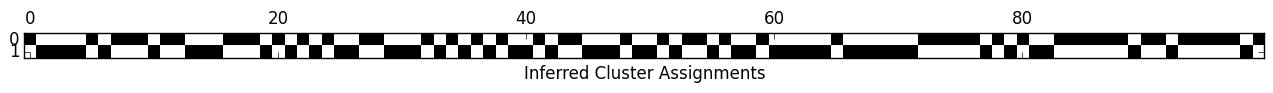

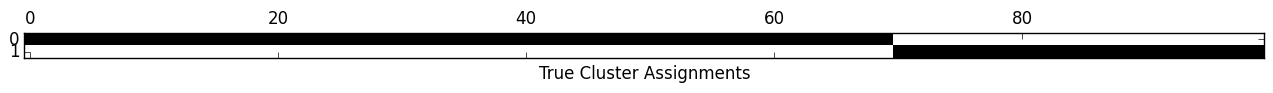

In [3]:
## Low-rank model with hard clustering regularization
evaluate_loss(quadratic(),unitonesparse(),zeroreg());

This doesn't seem to work well, since solving this optimization problem is NP-hard. Instead, we first consider the following relaxation:

$$
r_x(x) = \left\{\begin{matrix}
\infty & x \prec 0 \\ 
\sum_p x_p & \text{otherwise}
\end{matrix}\right.
$$

That is, we restrict all elements of $X$ to be nonnegative and we introduce an $\ell_1$ norm penalty on the rows of $X$. This encourages the rows of $X$ to be sparse.

Best Objective: 1763.3252181116136


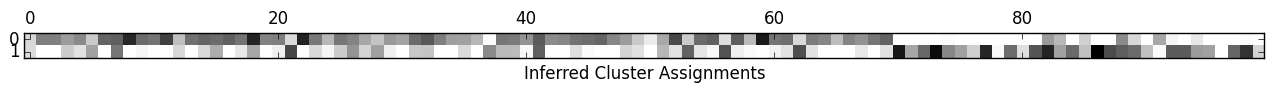

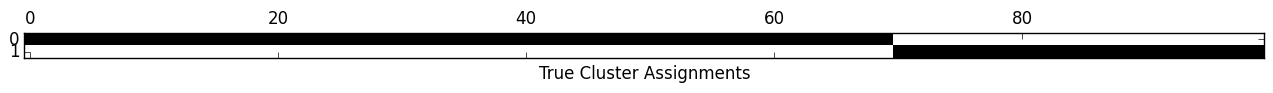

In [4]:
## Low-rank model with non-negative constraint and L1 norm penalty
X1,Y1,ch1 = evaluate_loss(quadratic(),nonneg_onereg(),zeroreg());

We see that this does a pretty good job of finding the correct clusters for each read. We can use this solution to initialize the hard clustering problem, and recover the ground truth clusters in the synthetic dataset:

Best Objective: 1840.5314477493964


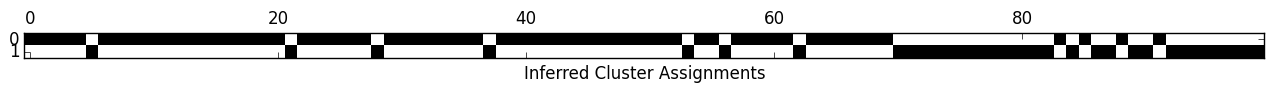

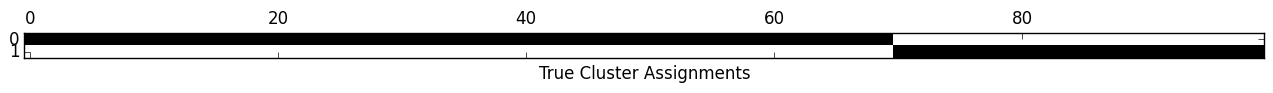

In [5]:
## Low-rank model with hard clustering regularization, with better initialization
X2,Y2,ch2 = evaluate_loss(quadratic(),unitonesparse(),zeroreg(),initX=X1,initY=Y1);

The matrix $Y$ (whose rows correspond to the methylation pattern) also appears to do a good job of matching the ground truth probability of methylation:

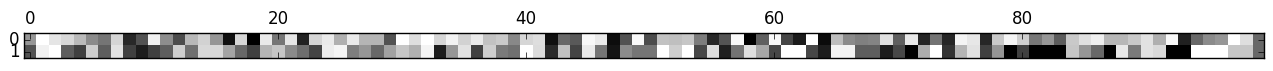

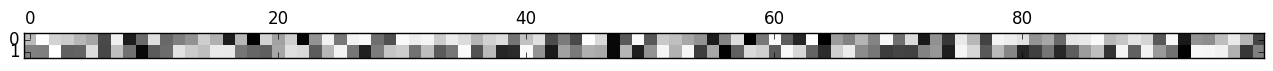

PyObject <matplotlib.image.AxesImage object at 0x7f5e827c80d0>

In [6]:
matshow(Y2,cmap=ColorMap("Greys"))
matshow(P,cmap=ColorMap("Greys"))

####TODO: implement a greedy algorithm that flips each clustering assignment and accepts it if it decreases the loss

### Logistic loss function doesn't seem work well

In the above analysis, I used a quadratic loss function. However, the logistic loss function would be more natural for our problem, since $A$ is composed of have binary data:

$$L(A_{ij},x_i,y_j) = \log(1+\exp(-A_{ij} (x_i y_j))$$

Surprisingly, a quadratic loss function seems to work better (see results below). This is still really puzzling to me, and I'm trying to figure out why this would be the case.

Best Objective: 2204.495232416909


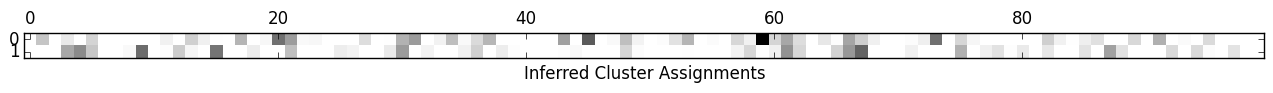

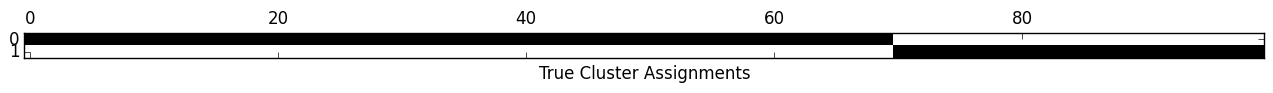

In [7]:
## Low-rank model with non-negative constraint and L1 norm penalty
X3,Y3,ch3 = evaluate_loss(logistic(),nonneg_onereg(),zeroreg());

Best Objective: 2108.6022466443487


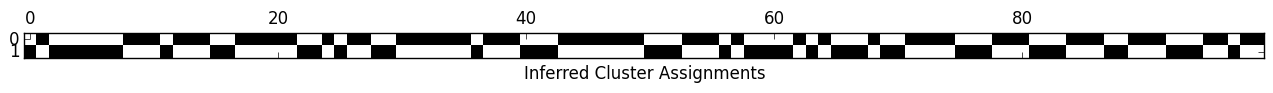

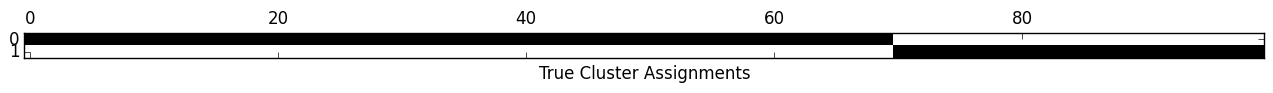

In [8]:
## Low-rank model with hard clustering regularization, with better initialization
X4,Y4,ch4 = evaluate_loss(quadratic(),unitonesparse(),zeroreg(),initX=X3,initY=Y3);

### Future Considerations

* What is the most reasonable way to initialize the optimization problem? Maybe the logistic loss would work better if the initial $X$ and $Y$ are reasonable.